# Example

In [3]:
    # Criar sessão Spark
    spark = SparkSession.builder.appName("BayesClassification").getOrCreate()

In [4]:
# Criar DataFrame com os dados
data = [
    ("Azul", "Grande", "Pesado", "A"),
    ("Vermelho", "Pequeno", "Leve", "B"),
    ("Azul", "Médio", "Médio", "A"),
    ("Vermelho", "Grande", "Pesado", "B"),
    ("Azul", "Pequeno", "Leve", "A"),
    ("Azul", "Grande", "Leve", "A"),
    ("Vermelho", "Médio", "Pesado", "B"),
    ("Azul", "Médio", "Leve", "A"),
    ("Vermelho", "Pequeno", "Médio", "B"),
    ("Azul", "Grande", "Médio", "A"),
]

In [5]:
columns = ["Cor", "Tamanho", "Peso", "Classe"]
df_train_ = spark.createDataFrame(data, columns)

In [6]:
df_train_.show()

+--------+-------+------+------+
|     Cor|Tamanho|  Peso|Classe|
+--------+-------+------+------+
|    Azul| Grande|Pesado|     A|
|Vermelho|Pequeno|  Leve|     B|
|    Azul|  Médio| Médio|     A|
|Vermelho| Grande|Pesado|     B|
|    Azul|Pequeno|  Leve|     A|
|    Azul| Grande|  Leve|     A|
|Vermelho|  Médio|Pesado|     B|
|    Azul|  Médio|  Leve|     A|
|Vermelho|Pequeno| Médio|     B|
|    Azul| Grande| Médio|     A|
+--------+-------+------+------+



In [7]:
data_test_ = [
    ("???", "Médio", "Pesado", "B"),  # Exemplo de teste com classe conhecida
    ("???", "Médio", "Médio", "A"),  # Outro exemplo de teste
    ("Azul", "Grande", "Médio", "A"),
    ("Rosa", "Pequeno", "Pesado", "B"),
]
df_test_ = spark.createDataFrame(data_test_, columns)
df_test_.show()

+----+-------+------+------+
| Cor|Tamanho|  Peso|Classe|
+----+-------+------+------+
| ???|  Médio|Pesado|     B|
| ???|  Médio| Médio|     A|
|Azul| Grande| Médio|     A|
|Rosa|Pequeno|Pesado|     B|
+----+-------+------+------+



In [55]:
def calculate_conditional_prob(df, feature, class_col="Classe"):
    feature_counts = df.groupBy(class_col, feature).agg(count(feature).alias("count"))
    class_counts = df.groupBy(class_col).agg(count("*").alias("class_count"))
    prob_df = feature_counts.join(class_counts, class_col).withColumn(
        f"P({feature}|{class_col})", col("count") / col("class_count")
    )
    return prob_df.drop("count", "class_count")

def get_prob(prob_df, classe, valor, feature_name):
    result = prob_df.filter((col("Classe") == classe) & (col(feature_name) == valor)).select(prob_df.columns[2]).collect()
    
    if result:
        return result[0][0]  
    
    # suavização de Laplace
    class_count = class_probs.filter(col("Classe") == classe).select("count").collect()[0][0]
    return 1.0 / (class_count + class_probs.count() + 1)

def bayes(df_train: DataFrame, df_test: DataFrame, target_col: str = "Classe") -> DataFrame:
    feature_cols = [c for c in df_train.columns if c != target_col]

    # P(Ck)
    class_probs = (
        df_train.groupBy(target_col)
        .agg(count("*").alias("count"))
        .withColumn("P(Ck)", col("count") / df_train.count())
        .drop("count")
        .collect()
    )
    class_probs_dict = {row[target_col]: row["P(Ck)"] for row in class_probs}
    classes_sorted = sorted(class_probs_dict.keys())  # para manter a ordem [0, 1]

    # P(x|Ck)
    feature_probs = {}
    for feature in feature_cols:
        prob_df = calculate_conditional_prob(df_train, feature, target_col)
        feature_probs[feature] = {
            (row[target_col], row[feature]): row[f"P({feature}|{target_col})"]
            for row in prob_df.collect()
        }

    # Previsão e montagem dos resultados
    results = []
    for row in df_test.toLocalIterator():
        probs = {}
        row_dict = row.asDict()

        for classe in classes_sorted:
            p_total = class_probs_dict[classe]
            for feature in feature_cols:
                key = (classe, row_dict.get(feature))
                p_feature = feature_probs[feature].get(
                    key, 1 / (df_train.count() + len(class_probs_dict))
                )  # Laplace smoothing
                p_total *= p_feature
            probs[classe] = p_total

        # Normalização das probabilidades
        total_prob = sum(probs.values())
        prob_vector = [probs[c] / total_prob for c in classes_sorted]

        # predicted_class = float(classes_sorted[prob_vector.index(max(prob_vector))])
        # true_class = float(row[target_col])
        predicted_class = classes_sorted[prob_vector.index(max(prob_vector))]
        true_class = row[target_col]
        

        results.append(Row(prediction=predicted_class, Classe=true_class, probability=prob_vector))

    # Criar DataFrame com os resultados
    result_df = df_train.sql_ctx.createDataFrame(results)
    result_df.show(10, truncate=False)

    # Acurácia
    correct_predictions = result_df.filter(col("prediction") == col("Classe")).count()
    total_samples = result_df.count()
    accuracy = correct_predictions / total_samples
    print(f"Acurácia: {accuracy:.2%}")

    return result_df

In [8]:
def calculate_conditional_prob(df, feature, class_col="Classe"):
    feature_counts = df.groupBy(class_col, feature).agg(count(feature).alias("count"))
    class_counts = df.groupBy(class_col).agg(count("*").alias("class_count"))
    prob_df = feature_counts.join(class_counts, class_col).withColumn(
        f"P({feature}|{class_col})", col("count") / col("class_count")
    )
    return prob_df.drop("count", "class_count")

def get_prob(prob_df, classe, valor, feature_name):
    result = prob_df.filter((col("Classe") == classe) & (col(feature_name) == valor)).select(prob_df.columns[2]).collect()
    
    if result:
        return result[0][0]  
    
    # suavização de Laplace
    class_count = class_probs.filter(col("Classe") == classe).select("count").collect()[0][0]
    return 1.0 / (class_count + class_probs.count() + 1)

def bayes(df_train: DataFrame, df_test: DataFrame, target_col: str = "Classe") -> DataFrame:
    feature_cols = [c for c in df_train.columns if c != target_col]

    # P(Ck)
    class_probs = (
        df_train.groupBy(target_col)
        .agg(count("*").alias("count"))
        .withColumn("P(Ck)", col("count") / df_train.count())
        .drop("count")
        .collect()
    )
    class_probs_dict = {row[target_col]: row["P(Ck)"] for row in class_probs}
    classes_sorted = sorted(class_probs_dict.keys()) 

    # P(x|Ck)
    feature_probs = {}
    for feature in feature_cols:
        prob_df = calculate_conditional_prob(df_train, feature, target_col)
        feature_probs[feature] = {
            (row[target_col], row[feature]): row[f"P({feature}|{target_col})"]
            for row in prob_df.collect()
        }

    # Previsão e montagem dos resultados
    results = []
    for row in df_test.toLocalIterator():
        probs = {}
        row_dict = row.asDict()

        for classe in classes_sorted:
            p_total = class_probs_dict[classe]
            for feature in feature_cols:
                key = (classe, row_dict.get(feature))
                p_feature = feature_probs[feature].get(
                    key, 1 / (df_train.count() + len(class_probs_dict))
                )  # suavização de Laplace 
                p_total *= p_feature
            probs[classe] = p_total

        # Normalização das probabilidades
        total_prob = sum(probs.values())
        prob_vector = [probs[c] / total_prob for c in classes_sorted]

        # predicted_class = float(classes_sorted[prob_vector.index(max(prob_vector))])
        # true_class = float(row[target_col])
        predicted_class = classes_sorted[prob_vector.index(max(prob_vector))]
        true_class = row[target_col]
        

        results.append(Row(prediction=predicted_class, Classe=true_class, probability=prob_vector))

    # Criar DataFrame com os resultados
    result_df = df_train.sql_ctx.createDataFrame(results)
    result_df.show(10, truncate=False)

    # Acurácia
    correct_predictions = result_df.filter(col("prediction") == col("Classe")).count()
    total_samples = result_df.count()
    accuracy = correct_predictions / total_samples
    print(f"Acurácia: {accuracy:.2%}")

    return result_df

In [11]:
result_df = bayes(df_train_, df_test_, "Classe")

+----------+------+-----------------------------------------+
|prediction|Classe|probability                              |
+----------+------+-----------------------------------------+
|B         |B     |[0.3999999999999999, 0.6]                |
|A         |A     |[0.7272727272727272, 0.27272727272727276]|
|A         |A     |[0.9795918367346939, 0.02040816326530612]|
|B         |B     |[0.14285714285714282, 0.8571428571428571]|
+----------+------+-----------------------------------------+

Acurácia: 100.00%


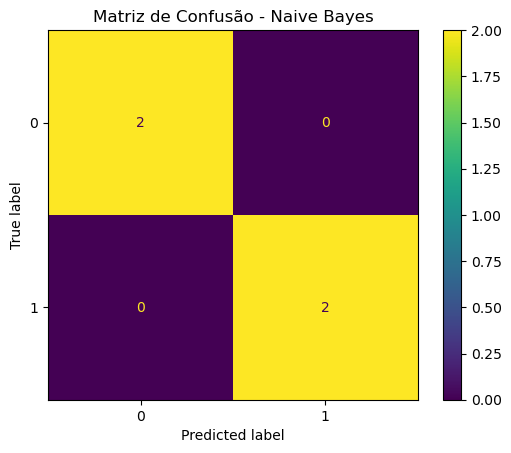

In [12]:
y_true = [row['Classe'] for row in result_df.collect()]
y_pred = [row['prediction'] for row in result_df.collect()]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()

# Teorema de Bayes

Importando bibliotecas

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, count
from pyspark.sql import Row
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pyspark.ml.feature import QuantileDiscretizer

Criando Sessão PySpark

In [2]:
spark = SparkSession.builder \
    .appName("Beyes-Theorem") \
    .getOrCreate()

Lendo dataframe de treino

In [3]:
parquet_path = "/home/jovyan/work/data/clean-data/train-data/creditcard_2023.parquet"

train_df = spark.read.parquet(parquet_path)

Lendo dataframe de treino

In [4]:
parquet_path = "/home/jovyan/work/data/clean-data/test-data/creditcard_2023.parquet"

test_df = spark.read.parquet(parquet_path)

Selecionando dados de treino

In [20]:
train_class_0 = train_df.filter(F.col("Class") == 0).limit(10000)
train_class_1 = train_df.filter(F.col("Class") == 1).limit(10000)
new_train_df = train_class_0.union(train_class_1)

In [21]:
new_train_df.groupBy("Class").count().orderBy("count", ascending=False).show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|10000|
|    1|10000|
+-----+-----+



Selecionando dados de teste

In [22]:
class_0 = test_df.filter(test_df.Class == 0).limit(500)
class_1 = test_df.filter(test_df.Class == 1).limit(500)
new_test_df = class_0.union(class_1)

In [23]:
new_test_df.groupBy("Class").count().orderBy("count", ascending=False).show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|  500|
|    1|  500|
+-----+-----+



Quantidade de dados de treino

In [24]:
new_train_df.count()

20000

Quantidade de dados de treino

In [25]:
new_test_df.count()

1000

Criar um vetor de recursos

In [26]:
feature_cols = [c for c in new_train_df.columns if c != "Class"]

In [27]:
for col_name in feature_cols:
    output_col = f"{col_name}_binned"
    
    if output_col not in new_train_df.columns:
        discretizer = QuantileDiscretizer(
            numBuckets=5,
            inputCol=col_name,
            outputCol=output_col,
            handleInvalid="skip"
        )
        model = discretizer.fit(new_train_df)
        new_train_df = model.transform(new_train_df)
        new_test_df = model.transform(new_test_df)

In [29]:
def calculate_conditional_prob(df, feature, class_col="Classe"):
    feature_counts = df.groupBy(class_col, feature).agg(count(feature).alias("count"))
    class_counts = df.groupBy(class_col).agg(count("*").alias("class_count"))
    prob_df = feature_counts.join(class_counts, class_col).withColumn(
        f"P({feature}|{class_col})", col("count") / col("class_count")
    )
    return prob_df.drop("count", "class_count")

def bayes(df_train: DataFrame, df_test: DataFrame, target_col: str = "Classe") -> DataFrame:
    feature_cols = [c for c in df_train.columns if c != target_col]

    total_train_count = df_train.count()  # linha nova

    class_counts_df = df_train.groupBy(target_col).agg(count("*").alias("count"))
    class_counts = class_counts_df.collect()
    class_probs_dict = {
        row[target_col]: row["count"] / total_train_count for row in class_counts
    }
    classes_sorted = sorted(class_probs_dict.keys())

    feature_probs = {}
    for feature in feature_cols:
        prob_df = calculate_conditional_prob(df_train, feature, target_col)
        feature_probs[feature] = {
            (row[target_col], row[feature]): row[f"P({feature}|{target_col})"]
            for row in prob_df.collect()
        }

    results = []
    for row in df_test.toLocalIterator(): 
        probs = {}
        row_dict = row.asDict()

        for classe in classes_sorted:
            p_total = class_probs_dict[classe]
            for feature in feature_cols:
                key = (classe, row_dict.get(feature))
                p_feature = feature_probs[feature].get(
                    key, 1 / (total_train_count + len(class_probs_dict))
                )
                p_total *= p_feature
            probs[classe] = p_total

        total_prob = sum(probs.values())
        prob_vector = [probs[c] / total_prob for c in classes_sorted]

        predicted_class = classes_sorted[prob_vector.index(max(prob_vector))]
        true_class = row[target_col]

        results.append(Row(prediction=predicted_class, Classe=true_class, probability=prob_vector))

    result_df = df_train.sql_ctx.createDataFrame(results)
    result_df.show(10, truncate=False)

    correct_predictions = result_df.filter(col("prediction") == col("Classe")).count()  # linha corrigida
    total_samples = result_df.count()
    accuracy = correct_predictions / total_samples
    print(f"Acurácia: {accuracy:.2%}")

    return result_df


In [30]:
binned_cols = [f"{col}_binned" for col in feature_cols]

In [31]:
result_df = bayes(
    new_train_df.select(binned_cols + ["Class"]),
    new_test_df.select(binned_cols + ["Class"]),
    target_col="Class"
)

/usr/local/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+----------+------+-------------------------------------------+
|prediction|Classe|probability                                |
+----------+------+-------------------------------------------+
|0         |0     |[0.9794833984561704, 0.020516601543829595] |
|0         |0     |[0.9342171558593487, 0.06578284414065129]  |
|0         |0     |[0.9999997156357098, 2.843642901705827E-7] |
|0         |0     |[0.9999999512999621, 4.870003788969457E-8] |
|0         |0     |[0.9999765983614095, 2.3401638590368354E-5]|
|1         |0     |[1.4749240426773993E-9, 0.9999999985250759]|
|0         |0     |[0.9657341477967323, 0.03426585220326769]  |
|0         |0     |[0.9998998130717683, 1.0018692823169014E-4]|
|0         |0     |[0.9999993871350299, 6.128649700035113E-7] |
|0         |0     |[0.9999973407051853, 2.659294814620364E-6] |
+----------+------+-------------------------------------------+
only showing top 10 rows

Acurácia: 99.60%


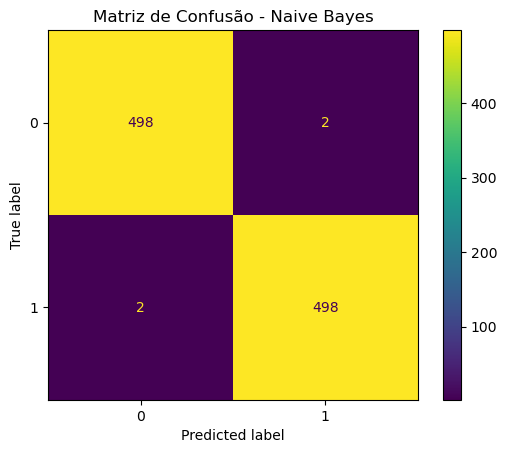

In [32]:
collected_result = result_df.select("Classe", "prediction").collect() 
y_true = [row['Classe'] for row in collected_result]  
y_pred = [row['prediction'] for row in collected_result]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()

Finalizando a sessão Spark

In [ ]:
spark.stop()